In [1]:
from libraries import MyDAQ
from libraries import functions as H
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx as dx
from scipy.signal import sawtooth, square
import libraries
from libraries import PMConverter
from scipy.fft import rfft, rfftfreq, irfft
import time
import random
import string
import scipy
all_list = [H.RC_C]

daq = MyDAQ()
daq.name = 'MyDAQ1'
daq.samplerate = 200000
read_channel = 'AI0'	
write_channel = 'AO0'
PM = PMConverter()

In [2]:
with open("bible.txt", "r", encoding="utf-8") as file:
    inhoud = file.read()

# Print eventueel de eerste 500 tekens ter controle
print(inhoud[:500])

ERV
English Revised Version
Genesis 1:1	In the beginning God created the heaven and the earth.
Genesis 1:2	And the earth was waste and void; and darkness was upon the face of the deep: and the spirit of God moved upon the face of the waters.
Genesis 1:3	And God said, Let there be light: and there was light.
Genesis 1:4	And God saw the light, that it was good: and God divided the light from the darkness.
Genesis 1:5	And God called the light Day, and the darkness he called Night. And there was eve


In [3]:
daq.name = 'MyDAQ1'
daq.samplerate = int(200000)
read_channel = 'AI1'	
write_channel = 'AO0'
capacity = 500
carrierFrequency = 20000
sps = int(daq.samplerate/capacity)
print('sps: ', sps)
amplitude = 8
#transfer function. UItzoeken hoe normaal werkt (telefoon), 
length = 0  # desired string length
random_string = ''.join(random.choices(string.ascii_letters, k=length))
text = inhoud[:1000] #"aaaaaaaaaa" #+ random_string
#print(text)
binary = PM.text_to_binary(text)
print('samples: ', len(binary) * sps)
fm_signal = PM.binary_to_pm(binary, fmType=1)
#fm_signal = np.zeros(40000)
print(fm_signal)
print('duration: ', len(fm_signal) * sps / daq.samplerate)

#print(fm_signal)

configuringSignal = np.tile(PM.binary_to_pm("00000010", fmType = 1), 5)
#PM.configuring_signal(daq.samplerate, sps, 32)
print(configuringSignal)
voltages = PM.pm_to_voltage_array(fm_signal, sps, f=carrierFrequency, fs=daq.samplerate, A=amplitude, pmConfigurationSignal=configuringSignal)

zeroess = np.zeros(87800)
voltages = np.concatenate([zeroess, voltages, zeroess])

sps:  400
samples:  3599600
[  0 180   0 ... 180 180 180]
duration:  16.0
[  0   0   0   0   0   0 180   0   0   0   0   0   0   0 180   0   0   0
   0   0   0   0 180   0   0   0   0   0   0   0 180   0   0   0   0   0
   0   0 180   0]


In [4]:
print('start in 3 sec')
time.sleep(0)
print('gooooo')
AI0_voltage = daq.readwrite(voltages, read_channel, write_channel)

bits = []

start in 3 sec
gooooo


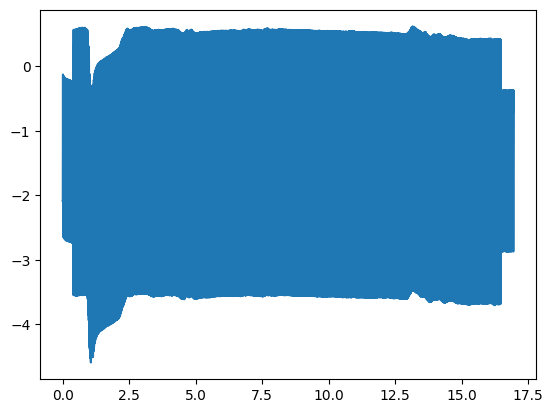

In [5]:
# Do the meaurement with MyDAQ


voltage_out = AI0_voltage # The second input channel is the voltage out over the breadboard component
timeArray = np.arange(len(voltage_out)) / daq.samplerate


plt.plot(timeArray, voltage_out)
plt.show()
# Save the data to a file
filename = "data"
np.savez(f"data/{filename}", time=timeArray, voltage=AI0_voltage)



[-2.09207719 -2.09305746 -2.09175043 ... -0.69943365 -0.69910689
 -0.70074068]


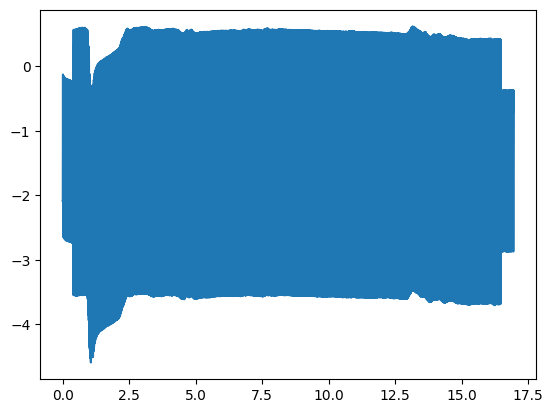

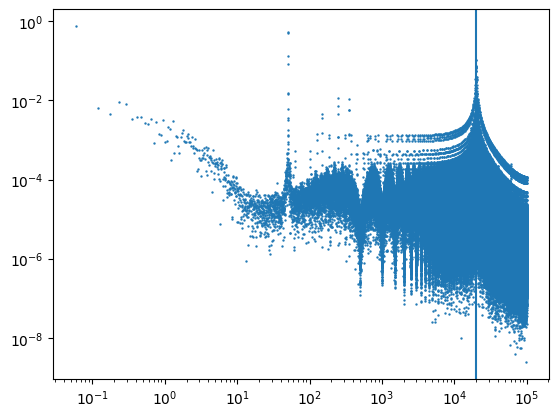

0.7585111781562572


In [6]:

data = np.load(f'data/{filename}.npz')
time_array = data['time']
voltage_out = data['voltage']
print(voltage_out)

plt.plot(time_array, voltage_out)
plt.show()

# Make hanning window for spectral leackage
hanning_window = np.hanning(len(voltage_out))

# Apply the window to the signal
AI0_voltage = AI0_voltage * hanning_window
freqs, fft_values = daq.performRFFT(AI0_voltage, daq.samplerate)

plt.scatter(freqs, np.abs(fft_values), s=0.5)
plt.xscale('log')
plt.yscale('log')
plt.axvline(20000)
plt.show()
print(np.max(np.abs(fft_values)))

In [7]:

def string_to_bitstream(message):
    
    """
    Converts a string to a list of bits (0s and 1s) using ASCII encoding.

    Example: "hi" -> [0,1,1,0,1,0,0,0, 0,1,1,0,1,0,0,1]
    """
    bitstream = []
    for char in message:
        ascii_val = ord(char)  # ASCII value
        bits = format(ascii_val, '08b')  # 8-bit binary string
        bitstream.extend([int(b) for b in bits])
    return bitstream
def bpsk_modulate(bitstream, bit_rate=1e3, carrier_freq=20e3, sampling_rate=daq.samplerate):
    """
    BPSK modulator.

    Parameters:
        bitstream      : list or array of bits (0s and 1s)
        bit_rate       : how many bits per second
        carrier_freq   : carrier frequency in Hz
        sampling_rate  : samples per second (must be >> carrier_freq)
    
    Returns:
        t              : time array
        dds_wave : the BPSK modulated signal
    """
    bitstream = np.array(bitstream)
    T_bit = 1 / bit_rate
    samples_per_bit = int(sampling_rate * T_bit)

    # Time array for the whole signal
    t = np.arange(0, len(bitstream) * T_bit, 1 / sampling_rate)
    
    # Phase values: 0 for bit 0, pi for bit 1
    phase_shifts = np.pi * bitstream.repeat(samples_per_bit)
    
    # Carrier
    carrier = 10*np.cos(2 * np.pi * carrier_freq * t + phase_shifts)
    
    return t, carrier, phase_shifts
def bpsk_demodulate(received_signal, bit_rate=1e3, carrier_freq=20e3, sampling_rate=daq.samplerate):
    """
    BPSK demodulator using correlation method.

    Parameters:
        received_signal : the BPSK signal (1D numpy array)
        bit_rate        : same as used in modulation
        carrier_freq    : same carrier frequency
        sampling_rate   : must match modulation
    
    Returns:
        recovered_bits  : list of 0s and 1s
    """
    T_bit = 1 / bit_rate
    samples_per_bit = int(sampling_rate * T_bit)
    num_bits = len(received_signal) // samples_per_bit

    recovered_bits = []

    for i in range(num_bits):
        # Slice for current bit
        segment = received_signal[i * samples_per_bit : (i + 1) * samples_per_bit]
        
        # Reference carrier (assumes perfect sync)
        t = np.arange(samples_per_bit) / sampling_rate
        reference = np.cos(2 * np.pi * carrier_freq * t)

        # Correlate (dot product / sum of product)
        product = segment * reference
        correlation = np.sum(product)
        #print(correlation)
        # Decision based on sign
        bit = 0 if correlation >= 0 else 1
        recovered_bits.append(bit)

    return recovered_bits
def bitstream_to_string(bitstream):
    """
    Converts a list of bits back into a string (assumes 8-bit ASCII).
    """
    chars = []
    for i in range(0, len(bitstream), 8):
        byte = bitstream[i:i+8]
        byte_str = ''.join(str(b) for b in byte)
        chars.append(chr(int(byte_str, 2)))
    return ''.join(chars)
def compare_bitstreams(original, received):
    """
    Compares two bitstreams and returns the percentage of correctly recovered bits.
    
    Parameters:
        original : list of original bits (0s and 1s)
        received : list of recovered bits (same length)

    Returns:
        accuracy_percentage : float
    """
    if len(original) != len(received):
        raise ValueError("Bitstreams must be of equal length.")
    
    correct = sum(o == r for o, r in zip(original, received))
    total = len(original)
    accuracy = (correct / total) * 100
    return accuracy
def format_bitstream(bitstream):
    pass

done correlation
BIT START: 78892


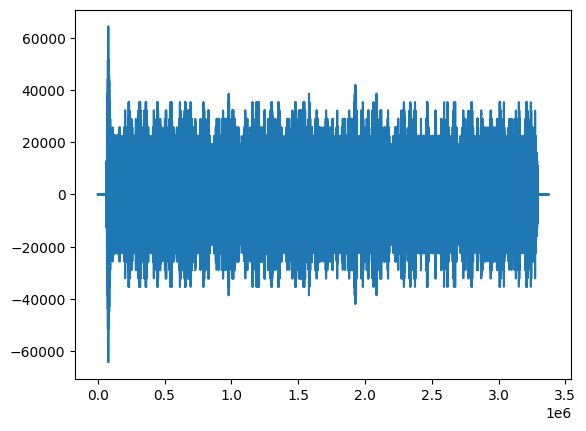

In [8]:
# Correlate with preamble to find start of message
PREAMBLE_BITS = [0,0,0,0,0,0,1,0]*5
t, preamble_waveform, phase_shifts = bpsk_modulate(PREAMBLE_BITS,  bit_rate=capacity, carrier_freq=carrierFrequency, sampling_rate=daq.samplerate)

received_signal = voltage_out
correlation = scipy.signal.correlate(received_signal, preamble_waveform, mode='valid')
print("done correlation")
bit_start = np.argmax(correlation)
print("BIT START:", bit_start)

plt.plot(correlation)
plt.show()

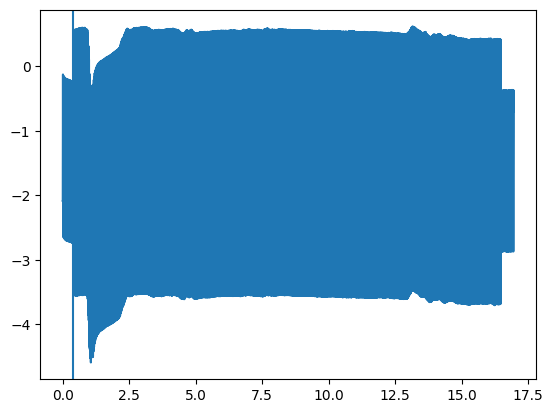

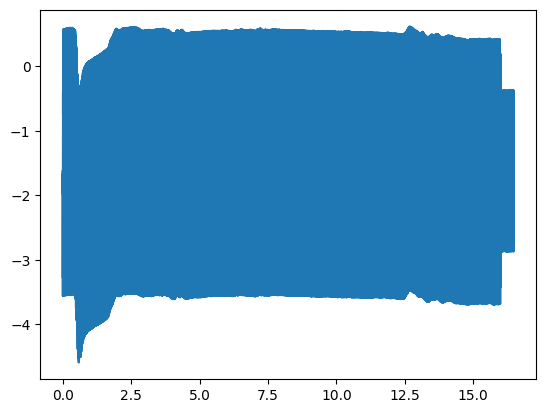

Decoded messageaaaaaaaaaaaaaaaaaa:
0333< Ì03<ü<?<ð<Ã?<À 3<3?<<Ã?<3<0 3<<3??<Ã<ÿ<ü Ì0?<3<ü<3?<Ã? Ì Ã0Ã<ü ?0<À<3 <<3<?<Ã<ü<ü<Ã<ü<? 0?<ÿ<0 <?<3<?0<3<0 ?0<À<3 <À<3<?<<3<ü <<ü<0 ?0<À<3 <3<??0<Àü Ì0?<3<ü<3?<Ã? Ì Ã0<ü<0 ?0<À<3 <3<??0<À ??<? ??<??0<3 <<ü<0 ?<<ÿ<Ã<0Ï <<ü<0 <0<?<Ï<ü<3?? ??<? ?3? <ÿ<ü ?0<À<3 <<<<<3 <ÿ<< ?0<À<3 <0<3<3? Ì <<ü<0 ?0<À<3 ?? <Ã?<Ã?0 <ÿ<< 0?<ÿ<0 <ó<ÿ?<<3<0 ?3? <ÿ<ü ?0<À<3 <<<<<3 <ÿ<< ?0<À<3 ??<?0<3??ü Ì0?<3<ü<3?<Ã? Ì Ã0<ü<0 0?<ÿ<0 ?<<Ã<0ð 0ð<3?0 ?0<À<3?<3 <<3 <ð<Ã<?<À?0Ì <<ü<0 ?0<À<3?<3 ??<? <ð<Ã<?<À?0ü Ì0?<3<ü<3?<Ã? Ì0 Ã0<ü<0 0?<ÿ<0 ?<?? ?0<À<3 <ð<Ã<?<À?0ð ?0<À<?0 <Ã?0 ??<? <?<ÿ<ÿ<0Ì <<ü<0 0?<ÿ<0 <0<Ã?<<Ã<0<3<0 ?0<À<3 <ð<Ã<?<À?0 <<?<ÿ<ó ?0<À<3 <0<?<Ï<ü<3??ü Ì0?<3<ü<3?<Ã? Ì3 Ã0<ü<0 0?<ÿ<0 <<<ð<ð<3<0 ?0<À<3 <ð<Ã<?<À?0 00<?Ãð <<ü<0 ?0<À<3 <0<?<Ï<ü<3?? <À<3 <<<ð<ð<3<0 0ü<Ã<?<À?0ü

(0.0, 0.008)

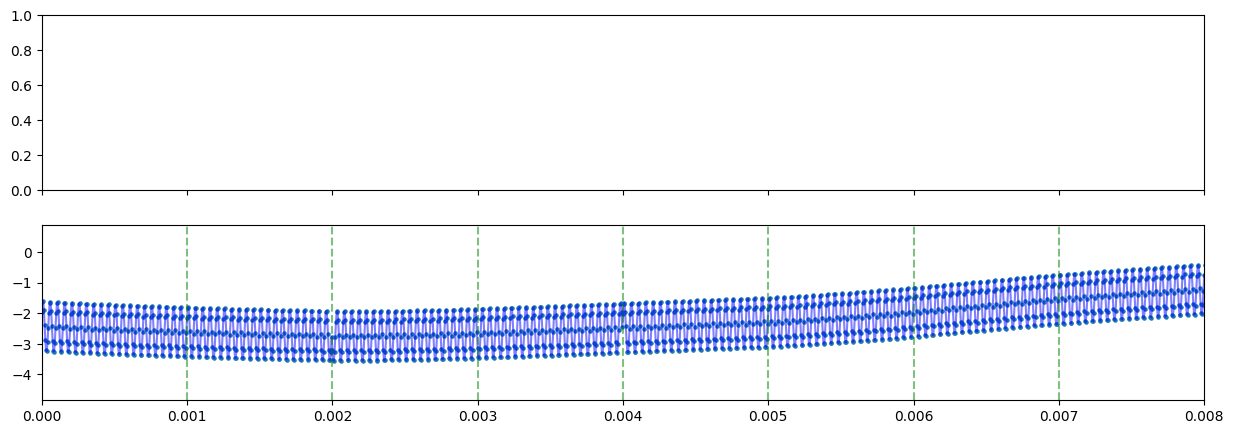

In [9]:
carrier_freq = 20e3
bit_rate = 1000




# Sending Signal -------------------------
# message = "The quick brown fox jumps over the lazy dog."
# bitstream = string_to_bitstream(message)
# # Add preamble to the bitstream
# bitstream = PREAMBLE_BITS + bitstream
# t, modulated, phase_shifts = bpsk_modulate(bitstream, bit_rate=bit_rate, carrier_freq=carrier_freq, sampling_rate=samplerate)

# # Receiving signal, add random noise -------------------------
# noise = np.random.normal(0, 5, size=modulated.shape)
# noise1 = np.sin(2 * np.pi * 50 * t) * 5
# received_signal =(modulated + noise + noise1) * 0.1

# # Add a delay to the received signal
# delay = 0.1
# delay_samples = int(delay * samplerate)
# received_signal = np.concatenate((np.zeros(delay_samples), received_signal))

#received_signal = daq.read(duration, readChannels)

received_signal = voltage_out
timeArray = np.arange(len(voltage_out)) / daq.samplerate
plt.plot(timeArray, received_signal)



plt.axvline(timeArray[bit_start])
plt.show()
idx = bit_start + len(preamble_waveform)
idx = idx - 2
received_signal = received_signal[idx:]
# Slice the received signal and begin coutning at 0 again
t1 = timeArray[idx:] - timeArray[idx]
plt.plot(t1,received_signal)
plt.show()
# Demodulate the received signal
bpsk_demodulated = bpsk_demodulate(received_signal, bit_rate=bit_rate, carrier_freq=carrier_freq, sampling_rate=daq.samplerate)
T_bit = 1 / bit_rate

# t1 = np.arange(0, (len(bitstream)-80)* T_bit, 1 / samplerate)

#print("Bpsk demoulated:", bpsk_demodulated)
# # Example:
decoded = bitstream_to_string(bpsk_demodulated)

# print("Original Message: ", message)
print("Decoded messageaaaaaaaaaaaaaaaaaa:")  # Should print "hello_world"
print(decoded)
# print("number of samples per bit: ", int(samplerate/bit_rate))
# print("Numbw=er of periods in bit:", carrier_freq/(bit_rate))
# print("duration of one bit: ", 1/bit_rate)
# print("Number of bits: ", len(bitstream))
# print("Duration whole message: ", len(bitstream)/bit_rate)



# # Plot the original and demodulated signals
# print("Original Bitstream:    ", bitstream)
# print("Demodulated Bitstream: ", bpsk_demodulated)
# accuracy = 0 #= compare_bitstreams(bitstream, bpsk_demodulated)
# print(f"Accuracy: {accuracy:.2f}%")

# # Plot Original data
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(15,5))
# plt.suptitle(f"BPSK Signal Modulation carrierfreq: {carrier_freq}Hz, bitrate: {bit_rate}bps, duration: {len(bitstream)/bit_rate}s")
# ax1.plot(t, modulated, color='blue', alpha=0.5)
# ax1.scatter(t, modulated, s=5)
# ax1.set_title("Transmitted Modulated Signal")

#ax2.set_title(f"Received Modulated Signal.  Accuracy:{accuracy}%, N samps per bit: {int(samplerate/bit_rate)}, N periods in bit: {carrier_freq/(bit_rate)},N bits: {len(bitstream)} ")
ax2.plot(t1, received_signal, color='blue', alpha=0.5)
ax2.scatter(t1, received_signal, s=5)

# ax1.fill_between(t, np.min(modulated), np.max(modulated), where=phase_shifts>0, color='pink', alpha=0.4)
# ax1.fill_between(t, np.min(modulated), np.max(modulated), where=phase_shifts==0, color='orange', alpha=0.4)
#ax2.fill_between(t, np.min(received_signal), np.max(received_signal), where=phase_shifts>0, color='pink', alpha=0.4)
#ax2.fill_between(t, np.min(received_signal), np.max(received_signal), where=phase_shifts==0, color='orange', alpha=0.4)

N_bits_to_plot = 8
N_words_to_plot = 1
# for i in range(N_words_to_plot *N_bits_to_plot):
#     ax1.axvline(i/bit_rate, color='g', linestyle='--')
for i in range(N_words_to_plot *N_bits_to_plot):
    ax2.axvline(i/bit_rate, color='g', linestyle='--', alpha=0.5)



plt.xlim(0, N_words_to_plot*N_bits_to_plot/bit_rate)
# ax2.set_xlabel("Time [s]")
# fig.text(0.003,0.5, 'Amplitude [V]', va='center', rotation='vertical')









# plt.tight_layout()
# plt.show()



In [10]:
decoded = bitstream_to_string(bpsk_demodulated)

def flip_bits(bit_array):
    return 1 - bit_array

print("Decoded messageaaaaaaaaaaaaaaaaaa:")  # Should print "hello_world"
print(bpsk_demodulated)
print(flip_bits(np.asarray(bpsk_demodulated)))
print(bitstream_to_string(flip_bits(np.asarray(bpsk_demodulated))))


Decoded messageaaaaaaaaaaaaaaaaaa:
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

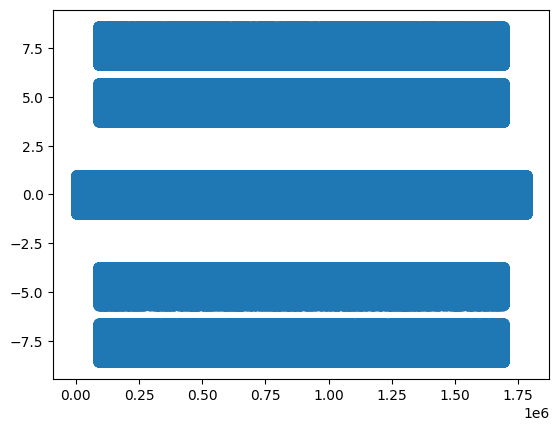

87801 1696799


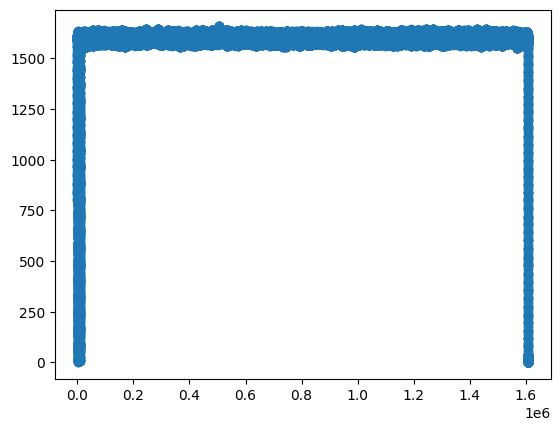

IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
data = voltages
noise = np.random.uniform(-1, 1, len(data))
data += noise

plt.scatter(np.arange(len(data)), data)
plt.show()
timeArray = np.arange(len(data)) / daq.samplerate
#print(data)+
thresholds = np.where(np.abs(data)>1.8)
print(thresholds[0][0], thresholds[0][-1] + 1000)
amplitudes = []
for i in range(thresholds[0][0]-100, thresholds[0][-1] + 1000):
    amplitude, phase = PM.lock_in_amplifier(data[i:i+sps], daq.samplerate, carrierFrequency, timeArray[i:i+sps])
    amplitudes.append(amplitude)
plt.scatter(range(0, len(amplitudes)), amplitudes)
plt.show()
indices = np.where(np.abs(np.array(amplitudes)) > 300)
start = indices[0][0] - 10
end = indices[0][-1] + 10
#print(start, end)
signal_slice = data[start:end]

_, _, phases = PM.retrieve_phases(signal_slice, daq.samplerate, sps, carrierFrequency)

phases += -phases[0]

binary = PM.pm_to_binary(phases, fmType=1)
text = PM.binary_to_text(binary)
print(binary)
print(text)

bits.append(binary)
#print(phases)

plt.scatter(range(start, end), signal_slice)
plt.show()

In [ ]:
for item in bits:
    print(item)

01010101 01010101 01010101 01010101 01110111 01010111 01010101 01010101 01100001 01100001 11100001 01100001 01100001 01100001 01100001 01110001 01100001 1110000
01010101 01010101 01010101 01010101 01010101 01010101 01010101 01010101 01100001 01100001 01100001 01100001 01100001 01100001 01100001 01100001 01100001 0110000
01110111 11011111 01010101 01010101 11110111 11010111 11010101 01110101 01111101 11101001 11101101 01111001 01110111 01110011 01111101 11100101 11110111 0110101


In [81]:
with open("bible.txt", "r", encoding="utf-8") as file:
    inhoud = file.read()

# Print eventueel de eerste 500 tekens ter controle
print(inhoud[:500])

ERV
English Revised Version
Genesis 1:1	In the beginning God created the heaven and the earth.
Genesis 1:2	And the earth was waste and void; and darkness was upon the face of the deep: and the spirit of God moved upon the face of the waters.
Genesis 1:3	And God said, Let there be light: and there was light.
Genesis 1:4	And God saw the light, that it was good: and God divided the light from the darkness.
Genesis 1:5	And God called the light Day, and the darkness he called Night. And there was eve


In [11]:
daq.name = 'MyDAQ1'
daq.samplerate = int(1000)
read_channel = 'AI0'	
write_channel = 'AO0'
carrierFrequency = 20000
sps = 100
amplitude = 2
#transfer function. UItzoeken hoe normaal werkt (telefoon), 
text = "aaaaaaaaaaAppelflappenkkkkkkkkkkkkkkkjhgkhgcvblkjgftuyseryiuygfcgfcgvhm,nxztretrertlukyeuyytkuygvcjghyukhgvcty6775i86oilki7r56tiyukljgdfguklhftrywuyturtgfjdfghuiy78i67yu"
binary = PM.text_to_binary(text)
#print(binary)
fm_signal = PM.binary_to_pm(binary, fmType=1)
#print(fm_signal)
configuringSignal = PM.configuring_signal(daq.samplerate, sps, 10)
#print(configuringSignal)
voltages = PM.pm_to_voltage_array(fm_signal, sps, f=carrierFrequency, fs=daq.samplerate, A=amplitude, pmConfigurationSignal=configuringSignal)


In [8]:
daq.write(voltages, write_channel)

In [ ]:
PM.configure_signal(voltages, daq.samplerate, carrierFrequency, sps, 10)


_, _, phases = PM.retrieve_phases(voltages, daq.samplerate, sps, carrierFrequency)
print('phases: ', np.round(np.array(phases) / np.pi * 180))

binary_back = PM.pm_to_binary(np.rad2deg(phases), fmType=1)
print("Recovered Binary:", binary_back)

text_back = PM.binary_to_text(binary_back)
print("Recovered Text:", text_back)

In [ ]:
daq.name = 'MyDAQ1'
daq.samplerate = int(2e5)
read_channel = 'AI0'	
write_channel = 'AO0'
carrierFrequency = 2e4
sps = 20000
amplitude = 2

text = "Hi!"
binary = PM.text_to_binary(text)
fm_signal = PM.binary_to_pm(binary, fmType=1)

voltages = PM.pm_to_voltage_array(fm_signal, sps, f=carrierFrequency, fs=daq.samplerate, A=amplitude)


In [ ]:
print(len(voltages))
#data = daq.readwrite(voltages, read_channel, write_channel)
data = voltages
window = np.hanning(len(data))
windowed_data = data * window
fft = np.fft.rfft(windowed_data)
freqs = np.fft.rfftfreq(len(data), 1 / daq.samplerate)
amplitude = np.abs(fft)

# Plot
#plt.figure(figsize=(10, 6))
#plt.scatter(freqs, amplitude, s=10, color='darkblue', alpha=0.7, label='FFT Amplitude')
#plt.axvline(carrierFrequency)
#lt.xscale('log')
#plt.yscale('log')  # Optional: helps when amplitudes span multiple orders
#plt.xlabel('Frequency (Hz)')
#plt.ylabel('Amplitude')
#plt.title('Frequency Spectrum (FFT)')
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
##plt.legend()
#plt.tight_layout()
#plt.show()

_, amplitudes, phases = PM.retrieve_phases(data, daq.samplerate, sps, carrierFrequency)

print(len(phases), len(fm_signal))

binary_back = PM.pm_to_binary(phases, fmType=1)
print("Recovered Binary:", binary_back)

text_back = PM.binary_to_text(binary_back)
print("Recovered Text:", text_back)

In [ ]:
plt.scatter(np.linspace(0, len(phases), len(phases)), phases)
plt.show()

In [ ]:
tArray = np.linspace(0, len(voltages) / daq.samplerate, len(voltages), endpoint=False)
print(voltages.shape)
data = daq.readwrite(voltages, read_channel, write_channel)
tArrayd = np.linspace(0, len(data) / daq.samplerate, len(data), endpoint=False)

print(len(tArrayd), len(data), len(voltages))

plt.scatter(tArray, voltages, s=1)  # s=1 to avoid huge dots
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Time-Domain Signal')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.scatter(tArrayd, data)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Time-Domain Signal')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
duration = 5
amplitude = 2
freq = 20000
phase = 0
_, signal = daq.generateWaveform('sine', daq.samplerate, freq, amplitude, phase, duration)
signal = []
for i in range(0, 6):
    for j in range(0, 20000):
        signal.append((i - 3))
data = daq.readwrite(np.array(signal), read_channel, write_channel)
plt.scatter(np.arange(len(signal)), signal, label='sig')
plt.scatter(np.arange(len(data)), data, label='data')
plt.legend()
plt.show()

print(len(signal) - len(data))
countt = 0
for i in range(0, 6):
    count = np.sum(np.abs(data - (i-3)) <= 0.1)
    countt += count
    print(f"{count} data points are within 0.1 V of 6 V.")
print(countt)
print(len(data))